<a href="https://colab.research.google.com/github/Abyukth-DA-code/SCT_ML_2/blob/main/SCT_ML_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loaded dataset with shape: (200, 5)


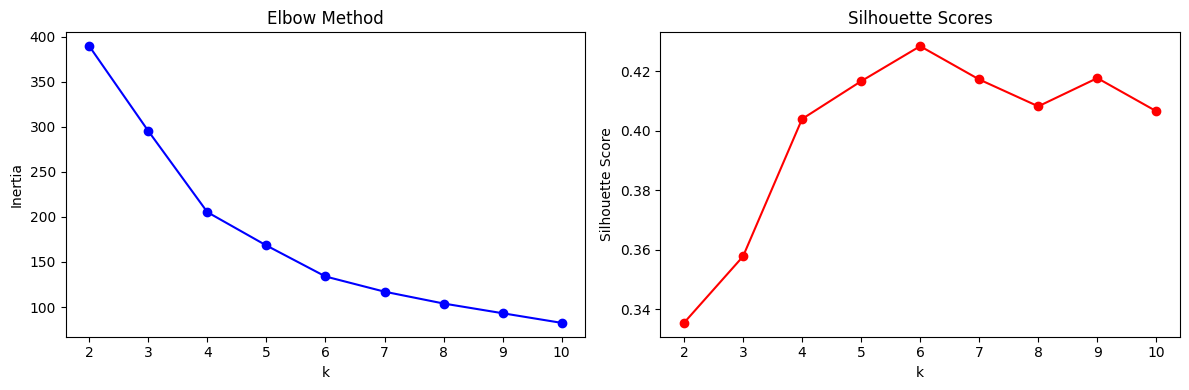

Auto-selected k (max silhouette): 6

Cluster profile (means):
           Age  Annual Income (k$)  Spending Score (1-100)  Size
Cluster                                                         
0        56.33               54.27                   49.07    45
1        26.79               57.10                   48.13    39
2        41.94               88.94                   16.97    33
3        32.69               86.54                   82.13    39
4        25.00               25.26                   77.61    23
5        45.52               26.29                   19.38    21

Saved clustered dataset to Mall_Customers_clustered.csv


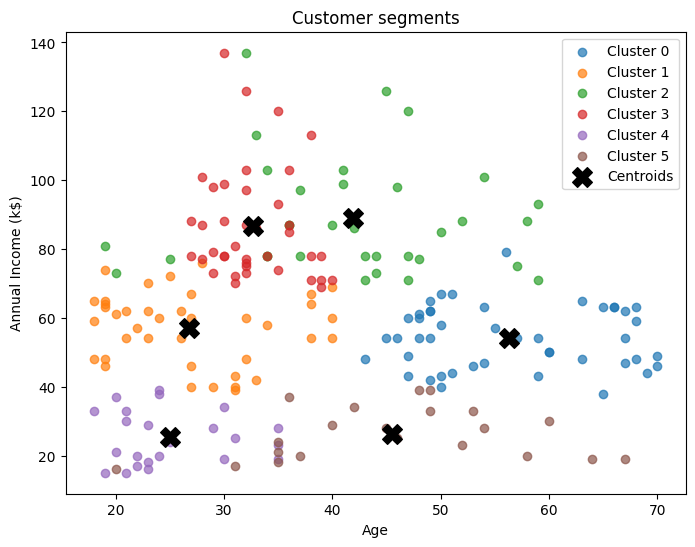

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# ---- Configuration ----
DATA_PATH = "Mall_Customers.csv"   # dataset filename provided by user
FEATURES = ["Age", "Annual Income (k$)", "Spending Score (1-100)"]  # typical Mall_Customers columns
RANDOM_STATE = 42

# ---- Step 1: Load Data ----
# Make sure the CSV is in the same folder or provide full path
df = pd.read_csv(DATA_PATH)
print(f"Loaded dataset with shape: {df.shape}")

# ---- Step 2: Basic cleaning / feature selection ----n
# Keep only the features that exist in the dataset
available_features = [f for f in FEATURES if f in df.columns]
if not available_features:
    raise ValueError(f"None of the expected features found in dataset. Available columns: {list(df.columns)}")
X = df[available_features].copy()

# Optional: drop rows with missing values in chosen features
X = X.dropna()

# ---- Step 3: Feature Scaling ----n
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---- Step 4: Choose optimal K (Elbow + Silhouette) ----
inertia = []
sil_scores = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

# Plot Elbow and Silhouette
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(list(K_range), inertia, 'bo-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(list(K_range), sil_scores, 'ro-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores')
plt.tight_layout()
plt.savefig('k_selection_plots.png')
plt.show()

# ---- Step 5: Fit final KMeans (choose k based on plots) ----
# Here we pick k as the index of max silhouette score (automated), but you can override
best_k = K_range[int(pd.Series(sil_scores).idxmax())]
print(f"Auto-selected k (max silhouette): {best_k}")

kmeans = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# ---- Step 6: Cluster profiling ----
profile = df.groupby('Cluster')[available_features].mean().round(2)
size = df['Cluster'].value_counts().sort_index()
profile['Size'] = size
print("\nCluster profile (means):")
print(profile)

# Save clustered data
df.to_csv('Mall_Customers_clustered.csv', index=False)
print('\nSaved clustered dataset to Mall_Customers_clustered.csv')

# ---- Step 7: 2D visualization (if at least 2 features available) ----
if len(available_features) >= 2:
    x_feat, y_feat = available_features[0], available_features[1]
    plt.figure(figsize=(8,6))
    for cl in sorted(df['Cluster'].unique()):
        subset = df[df['Cluster'] == cl]
        plt.scatter(subset[x_feat], subset[y_feat], label=f'Cluster {cl}', alpha=0.7)

    # plot centroids (inverse transform)
    centroids = scaler.inverse_transform(kmeans.cluster_centers_)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, c='black', label='Centroids')
    plt.xlabel(x_feat)
    plt.ylabel(y_feat)
    plt.title('Customer segments')
    plt.legend()
    plt.savefig('cluster_plot.png')
    plt.show()

# ---- Step 8: Quick actionables ----
# The script writes:
# - Mall_Customers_clustered.csv  (original data + Cluster column)
# - k_selection_plots.png         (elbow + silhouette)
# - cluster_plot.png              (2D plot of first two features)

# You can further add: descriptive labels for clusters, export cluster centers in original units, or create a dashboard.
